In [19]:
#ALLOW TRAINING OF PRESET WEIGHTS

In [85]:
import os
import pandas as pd

os.chdir('/Users/jacksonwalters/tensorflow_datasets')
filepath_dict = {'tweet':   'labeled_tweets/all_labeled_tweets.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Tune in 11:30 ET tomorrow for a live webcast o...
label                                                       0
source                                                  tweet
Name: 0, dtype: object


In [86]:
#vectorize the data using a tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
#slice the df to get yelp sentences
df_tweet = df[df['source'] == 'tweet']
sentences = df_tweet['sentence'].values
#tweet sentence sentiment labels. 0 = negative, 1 = positive
y = df_tweet['label'].values
#split the sentences into training data and test data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)
#vectorize the sentences
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1  
#pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [87]:
vocab_size

19415

In [88]:
#plotting function for accuracy metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [89]:
#create an embedding matrix. index of word corresponds to wordvector.
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [90]:
embedding_dim = 10
embedding_matrix = create_embedding_matrix('glove/glove.6B.50d.txt',
                                           tokenizer.word_index, embedding_dim)

In [91]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.5877929436003091

In [102]:
#build the model
from keras import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 10)           194150    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 194,271
Trainable params: 194,271
Non-trainable params: 0
_________________________________________________________________


Epoch 1/8
905/905 [==============================] - 10s 12ms/step - loss: 0.0736 - accuracy: 0.9724 - val_loss: 0.1324 - val_accuracy: 0.9463
Epoch 2/8
905/905 [==============================] - 10s 11ms/step - loss: 0.0605 - accuracy: 0.9780 - val_loss: 0.1292 - val_accuracy: 0.9496
Epoch 3/8
905/905 [==============================] - 10s 11ms/step - loss: 0.0511 - accuracy: 0.9829 - val_loss: 0.1258 - val_accuracy: 0.9536
Epoch 4/8
905/905 [==============================] - 10s 12ms/step - loss: 0.0424 - accuracy: 0.9860 - val_loss: 0.1255 - val_accuracy: 0.9542
Epoch 5/8
905/905 [==============================] - 10s 11ms/step - loss: 0.0354 - accuracy: 0.9894 - val_loss: 0.1276 - val_accuracy: 0.9539
Epoch 6/8
905/905 [==============================] - 11s 12ms/step - loss: 0.0297 - accuracy: 0.9909 - val_loss: 0.1282 - val_accuracy: 0.9559
Epoch 7/8
905/905 [==============================] - 11s 12ms/step - loss: 0.0249 - accuracy: 0.9928 - val_loss: 0.1318 - val_accuracy: 0.9559

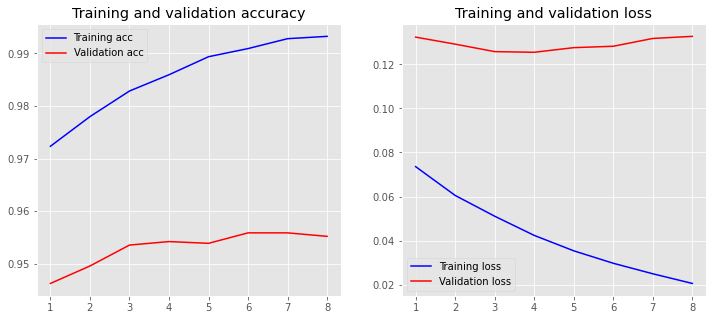

In [104]:
#train the model
history = model.fit(X_train, y_train,
                    epochs=8,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [111]:
#test examples
ex_sent = "We should lower taxes."
X_ex_sent = tokenizer.texts_to_sequences([ex_sent])
model.predict(pad_sequences(X_ex_sent, padding='post', maxlen=maxlen))

array([[0.50770646]], dtype=float32)